In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
import ase
import glob
import tqdm
import numpy as np
import ase.io as aio

from toolz.curried import pipe, curry, compose

In [3]:
import filters
import stats as astat
import utilities as utils

In [4]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [6]:
cutoff = 17.0
r_stat = 15.0
len_pixel = 10.0 

In [7]:
ix=0
run = runs[ix]


atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=2000)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

f_stat = "data/stats_new/dump.arc.{}_stat.pkl".format(run)
stat = utils.load_file(f_stat)

total atoms: 4000000, disturbed atoms: 0


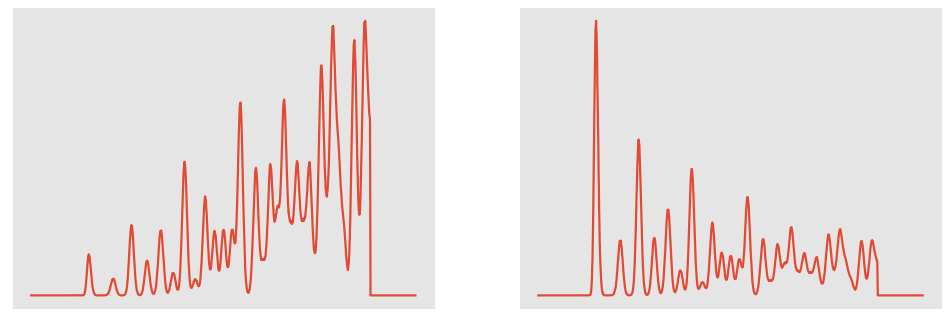

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
axs[0].plot(stat["bins"], stat["rdf"])
axs[1].plot(stat["bins"], stat["pdf"])

for ax in axs:
    # Hide grid lines
    ax.grid(False)
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

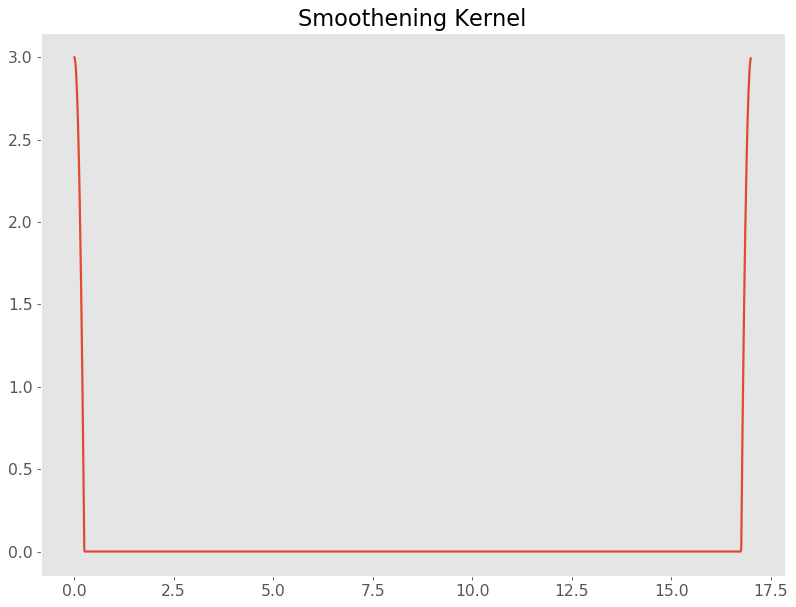

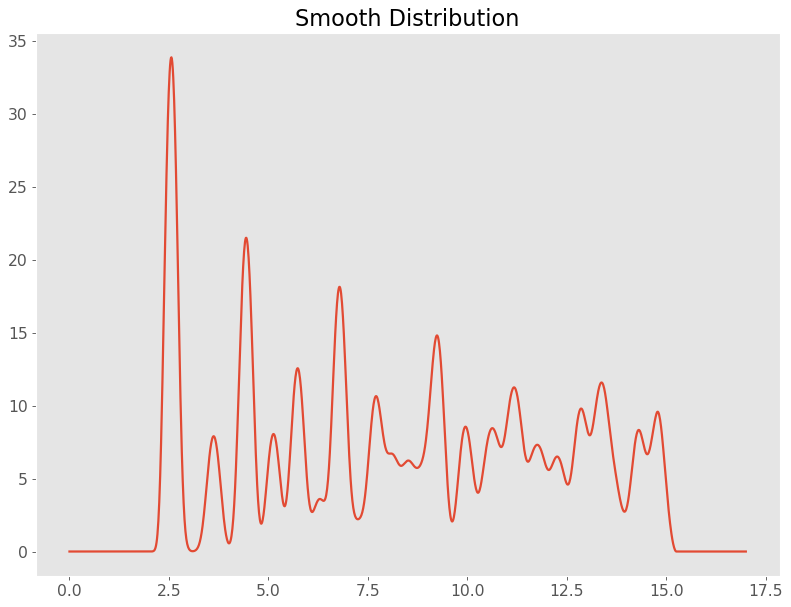

In [9]:
kernel = filters.epanechnikov_kernel(width=0.25, x=stat["bins"])
new_pdf = filters.convolve_kernel(kernel)(stat["pdf"])


plt.plot(stat["bins"], kernel)
plt.title("Smoothening Kernel")
plt.grid(b=None)
plt.show()


plt.plot(stat["bins"], new_pdf)
plt.title("Smooth Distribution")
plt.grid(b=None)
plt.show()

In [10]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray([int(2*r_stat*len_pixel + 1) + int(2 * r_s * len_pixel)]*3)

fs = pipe(r_s, 
          lambda r_s: filters.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape), 
          lambda s: filters.imfilter(arg1=s, arg2=s) / np.count_nonzero(s))


smooth_box = compose(lambda s: filters.imfilter(arg1=s, arg2=fs), 
                     lambda s: utils.padder(s, new_shape))

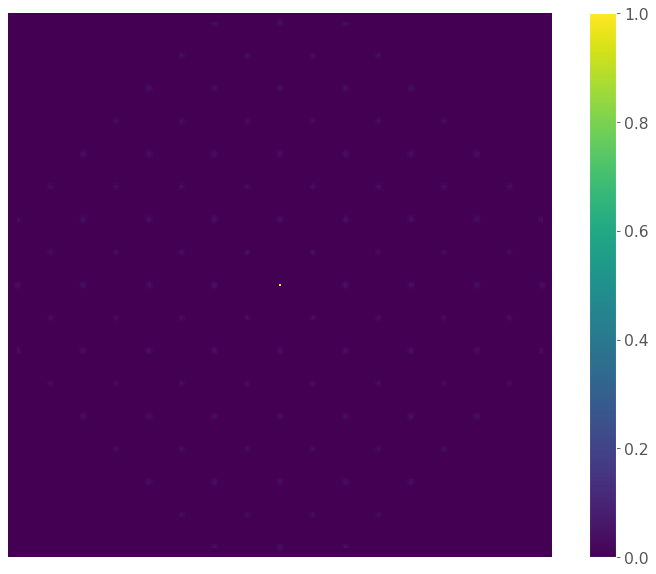

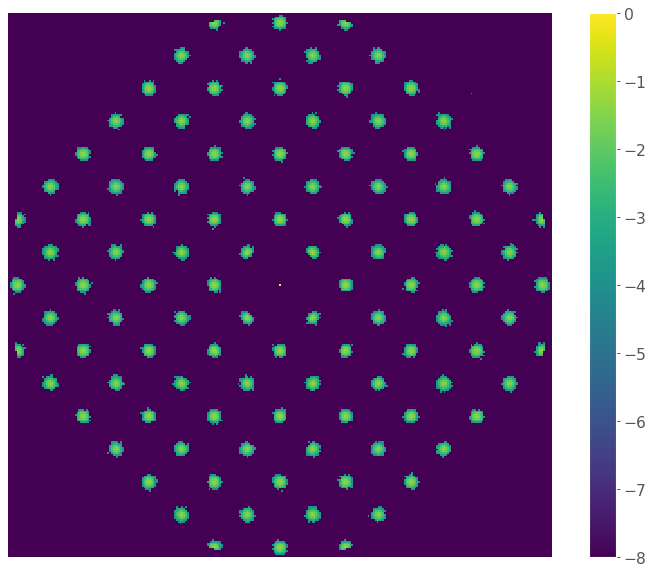

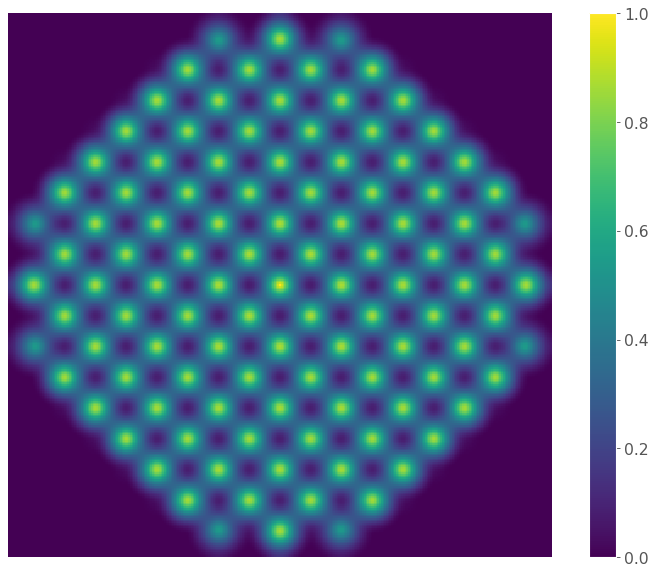

In [11]:
idx = int(r_stat * len_pixel)
box = stat["box"]
utils.draw_im(box[:,:, idx])
utils.draw_im(np.log10(box[:,:,idx]+1e-8))

idx = int((r_stat + r_s) * len_pixel)
utils.draw_im(smooth_box(box)[:,:,idx])

In [12]:
cutoff = 17.0
r_stat = 15.0
len_pixel = 10.0 

In [13]:
kernel = filters.epanechnikov_kernel(width=0.25, x=stat["bins"])

r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray([int(2*r_stat*len_pixel + 1) + int(2 * r_s * len_pixel)]*3)

fs = pipe(r_s, 
          lambda r_s: filters.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape), 
          lambda s: filters.imfilter(arg1=s, arg2=s) / np.count_nonzero(s))


smooth_box = compose(lambda s: filters.imfilter(arg1=s, arg2=fs), 
                     lambda s: utils.padder(s, new_shape))

In [28]:
rdf_list = []
tpt_list = []
n_atoms_irr = []

for run in tqdm.tqdm_notebook(runs):
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

    idx = np.where(atoms.get_tags() != 1)[0]
    print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

    if len(idx) == 0:
        np.random.seed(81396)
        idx = np.random.randint(low=0, high=len(atoms), size=2000)

    coords_all = atoms.get_positions()
    coords_sub = coords_all[idx]

    f_stat = "data/stats_new/dump.arc.{}_stat.pkl".format(run)
    stat = utils.load_file(f_stat)
    
    rdf_list.append(filters.convolve_kernel(kernel)(stat["pdf"]))
    tpt_list.append(smooth_box(stat["box"]))
    n_atoms_irr.append(stat["n_irr"])

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


total atoms: 4000000, disturbed atoms: 0
total atoms: 4000000, disturbed atoms: 87589
total atoms: 4000000, disturbed atoms: 132505
total atoms: 4000000, disturbed atoms: 171079
total atoms: 4000000, disturbed atoms: 182610
total atoms: 4000000, disturbed atoms: 189780
total atoms: 4000000, disturbed atoms: 207399
total atoms: 4000000, disturbed atoms: 206487
total atoms: 4000000, disturbed atoms: 205043
total atoms: 4000000, disturbed atoms: 242254
total atoms: 4000000, disturbed atoms: 244316
total atoms: 4000000, disturbed atoms: 274957
total atoms: 4000000, disturbed atoms: 272163
total atoms: 4000000, disturbed atoms: 259587
total atoms: 4000000, disturbed atoms: 259220
total atoms: 4000000, disturbed atoms: 254992
total atoms: 4000000, disturbed atoms: 289464
total atoms: 4000000, disturbed atoms: 277355
total atoms: 4000000, disturbed atoms: 266384
total atoms: 4000000, disturbed atoms: 261720
total atoms: 4000000, disturbed atoms: 252704
total atoms: 4000000, disturbed atoms: 2

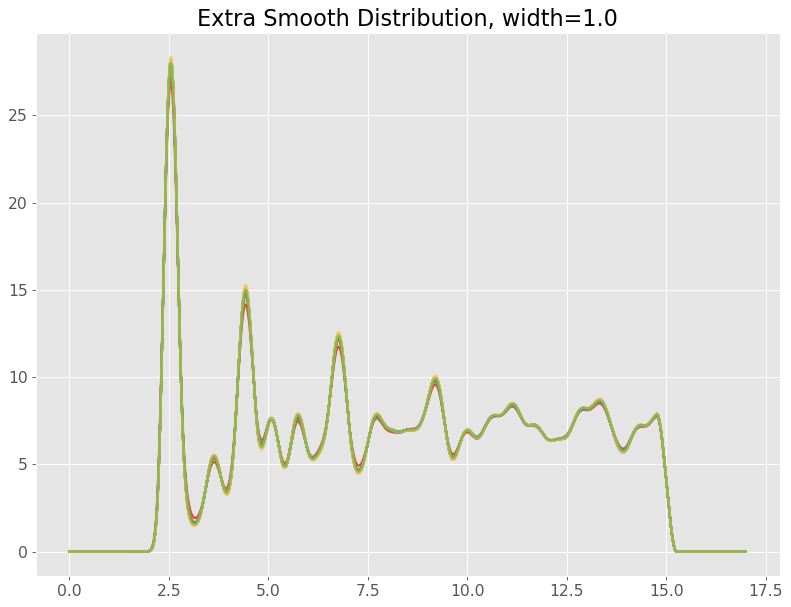

In [26]:
for i in np.random.randint(1, len(rdf_list), 20):
    plt.plot(stat["bins"], rdf_list[i])
plt.title("Extra Smooth Distribution, width=0.25")
plt.show()

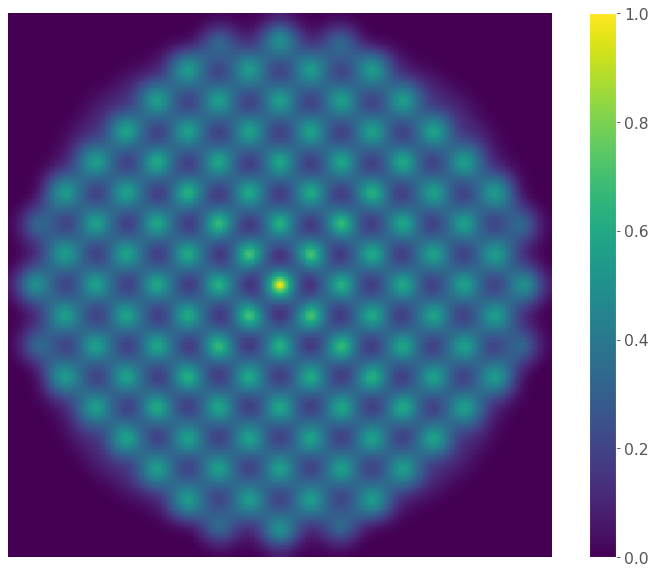

In [39]:
idx = int((r_stat + r_s) * len_pixel)
utils.draw_im(tpt_list[-10][:,:,idx])

## Model Building

In [31]:
from sklearn.decomposition import PCA

[9.61772424e-01 2.94675548e-02 5.83120048e-03 1.73452055e-03
 6.03213137e-04 2.67161084e-04 7.56461044e-05 5.02511117e-05
 4.65140330e-05 3.25555565e-05]


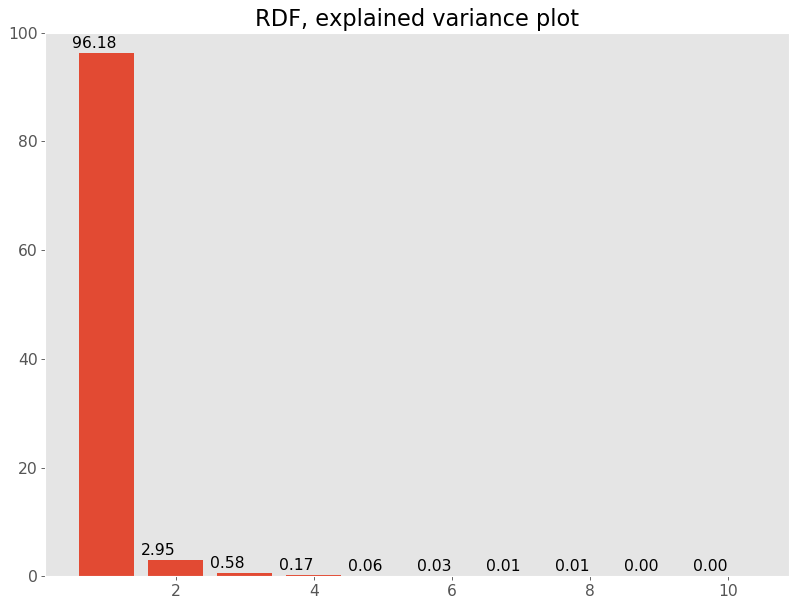

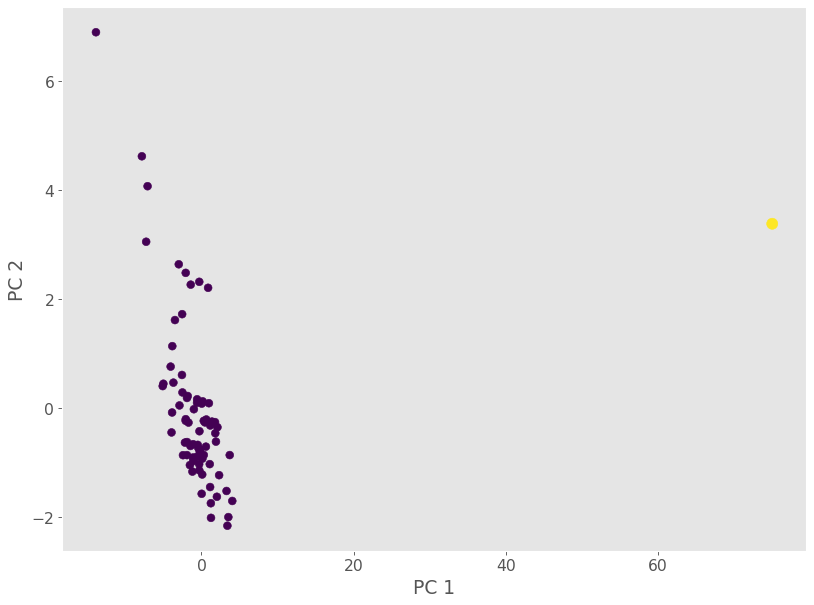

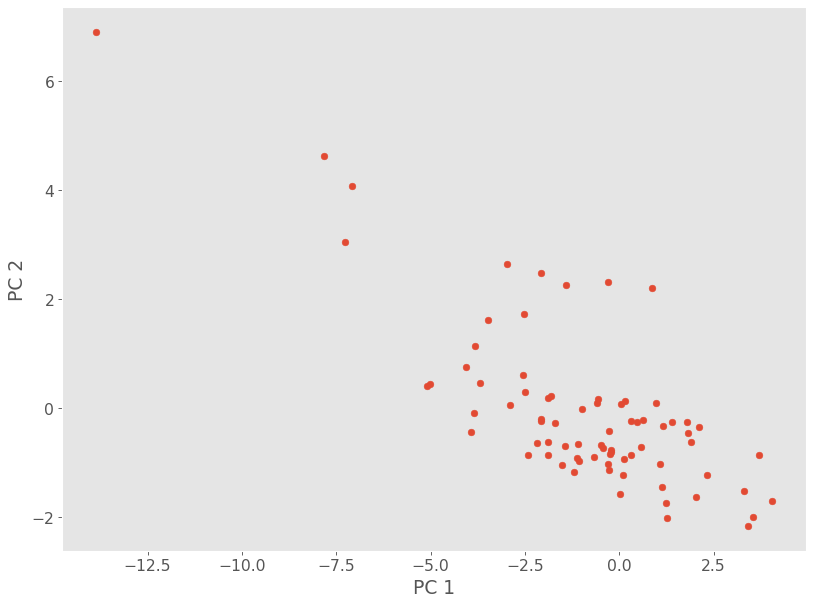

In [103]:
x_data = np.concatenate([item[None] for item in rdf_list], axis=0)

pca = PCA(n_components=10)
scores_rdf = pca.fit_transform(x_data)
print(pca.explained_variance_ratio_)

ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("RDF, explained variance plot")
plt.grid(b=None)
plt.show()


label = [50] * len(scores_rdf)
label[0] = 100
plt.scatter(scores_rdf[:,0], scores_rdf[:,1], c=label, s=label)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(b=None)
plt.show()

plt.scatter(scores_rdf[1:,0], scores_rdf[1:,1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(b=None)
plt.show()

## Correlation with SAED

In [257]:
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
# img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

img_saed_list = utils.load_file("data/saed_masked_imgs_hid.pkl")
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

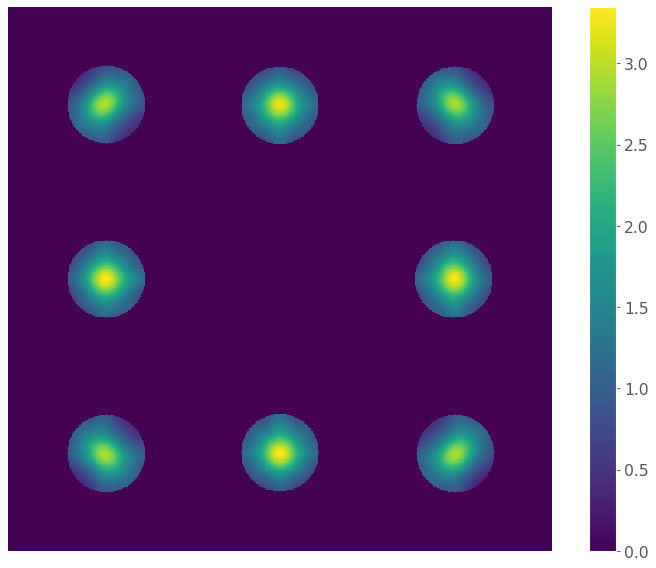

In [258]:
utils.draw_im(img_saed_list[-10])

[0.85804474 0.03223475 0.01216255 0.00992332 0.00837745 0.00665006
 0.00644661 0.00556939 0.00468204 0.00414346]


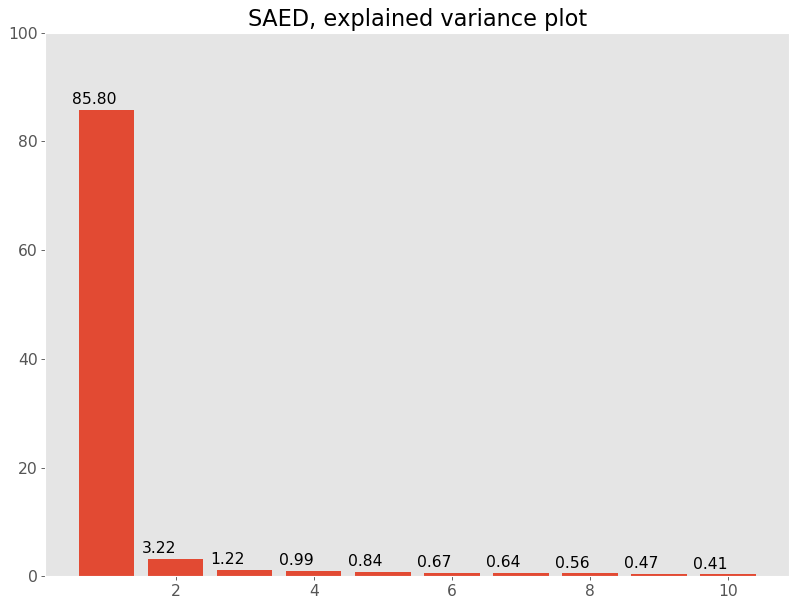

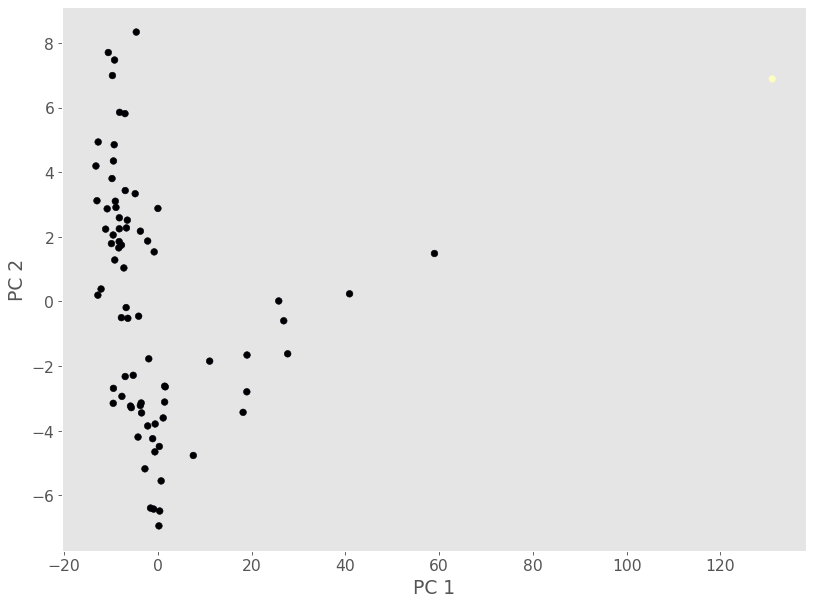

In [259]:
pca = PCA(n_components=10)
scores_saed = pca.fit_transform(img_saed)
print(pca.explained_variance_ratio_)

ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("SAED, explained variance plot")
plt.grid(b=None)
plt.show()

label = [1] * len(scores_saed)
label[0] = 2
plt.scatter(scores_saed[:,0], scores_saed[:,1], c=label, cmap="magma")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(b=None)
plt.show()

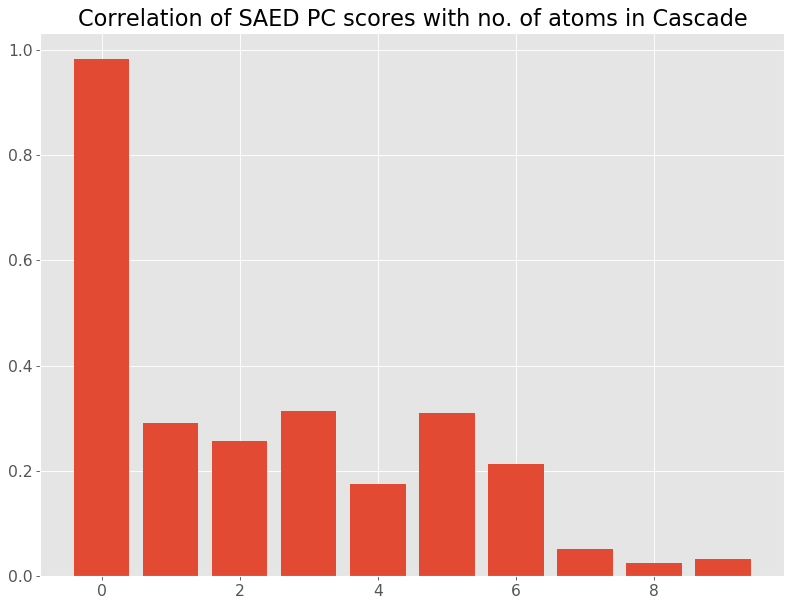

In [260]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], n_atoms_irr[1:])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with no. of atoms in Cascade")
plt.show()

In [262]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], scores_y[1:,0])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with PC 1 of Stat")
plt.show()


corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], scores_y[1:,1])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with PC 2 of Stat")
plt.show()

corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], scores_y[1:,2])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with PC 3 of Stat")
plt.show()

NameError: name 'scores_y' is not defined

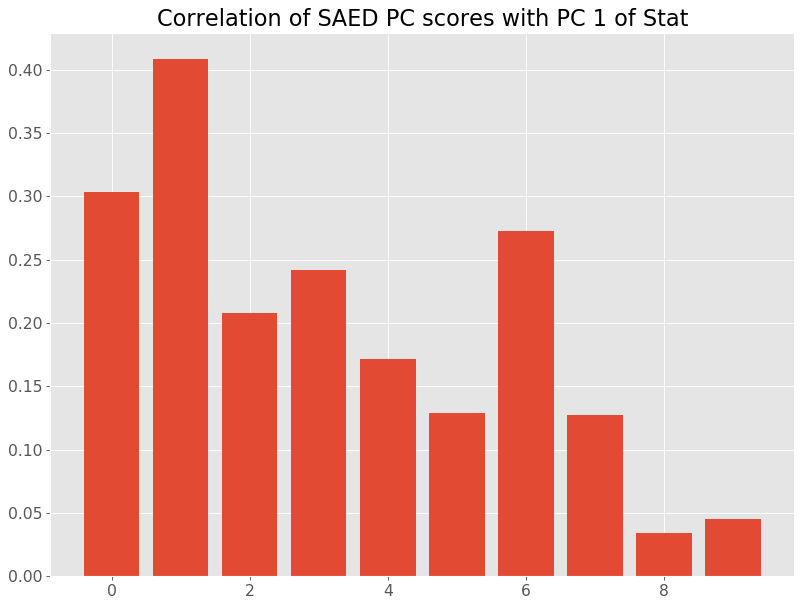

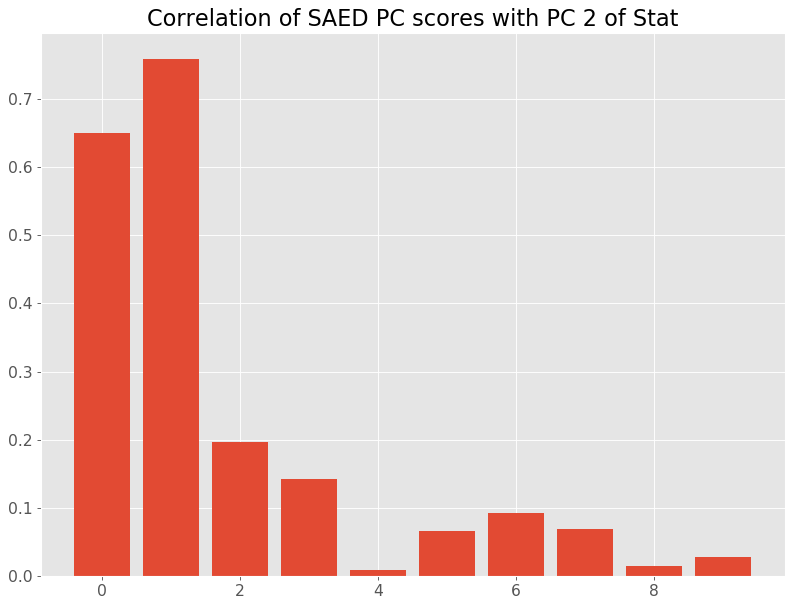

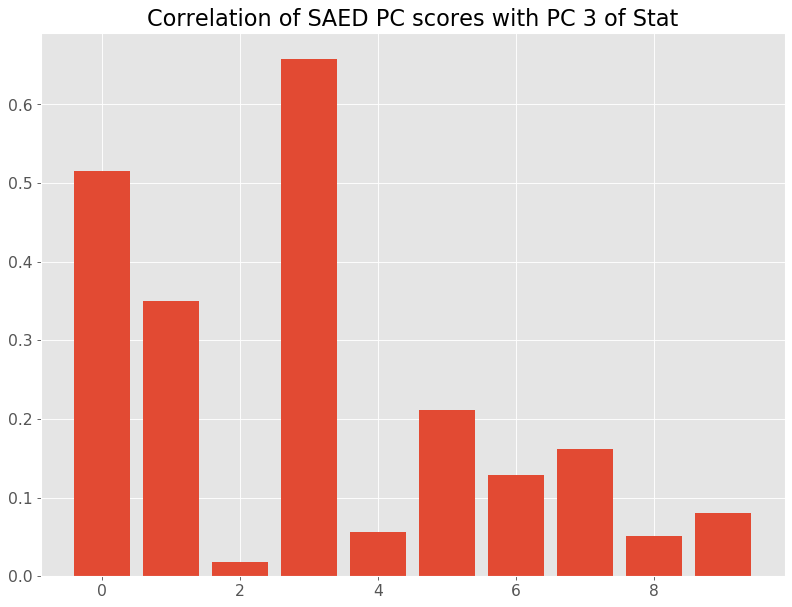

In [264]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], y_score[1:,0])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with PC 1 of Stat")
plt.show()


corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], y_score[1:,1])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with PC 2 of Stat")
plt.show()

corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores_saed[1:,ix], y_score[1:,2])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of SAED PC scores with PC 3 of Stat")
plt.show()

In [118]:
import GPy
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, BayesianRidge


maerror = lambda y1, y2: np.mean(np.fabs(y1-y2))

get_rbf_kernel = curry(lambda dim, var, scl, ard: GPy.kern.RBF(input_dim=dim, 
                                                    variance=var, 
                                                    lengthscale=scl, 
                                                    ARD=ard))

@curry
def gpr_trn(x_data, y_data, scl=1.0, var=1.0, ard=True):
    
    if type(scl) is not list:
        scl = [scl] * x_data.shape[1] if ard else scl
    
    kernel = get_rbf_kernel(dim=x_data.shape[1], var=var, scl=scl, ard=ard)
    
    model = GPy.models.GPRegression(x_data, y_data, kernel)
    model.optimize();
    return model, kernel


@curry
def gpr_prd(x_data, model):
    y_prd, y_var = model.predict(x_data)
    return y_prd, np.sqrt(y_var)


@curry
def get_pca(x_data, n_comp):
    pca = PCA(n_components=n_comp)
    f_data = pca.fit(x_data)
    return pca


def get_smooth_rdf(width):
    
    rdfs = np.load("rdfs/rdf_spiky_7_200_.npy")
    
    if width > 0.0:
        bins = np.linspace(0, 7.0, rdfs.shape[1]+1)
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        kernel = epanechnikov_kernel(width=width, x=bin_centers)
        rdfs_smooth = convolve_kernel(kernel, rdfs)
        return rdfs_smooth
    else:
        return rdfs
    

@curry
def gpr_model_full(X_data, y_data, n_splits=5, n_repeats=10, seed=2652124, scl=None, var=None):

    X = X_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    
    generator = rkf.split(X)

    errs_mae = []
    errs_gpr = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        pca = get_pca(X_trn, n_comp=15)

        transformer_x = lambda x: pca.transform(x)
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)
        
        if var is None:
            var = np.var(y_inp)
            
        if scl is None:
            scl = list(np.sqrt(pca.explained_variance_))
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=scl, 
                               var=var, 
                               ard=True)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)

            errs_mae.append(maerror(y_prd_m, y_tst))
        except Exception as err:
            print(err)
        
    return errs_mae, errs_gpr

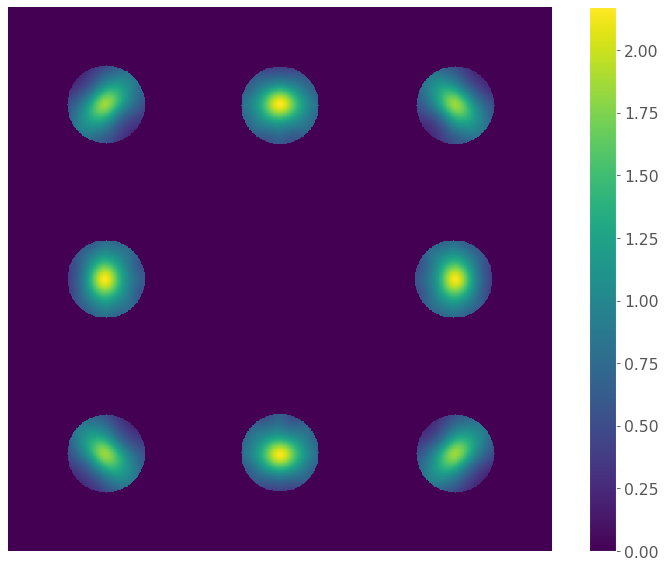

In [252]:
img_saed_list = utils.load_file("data/saed_masked_imgs_hid.pkl")
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

utils.draw_im(img_saed_list[0])

test set mae: mean:6094.17643, std:1165.32711
Normalized mae: 0.02235


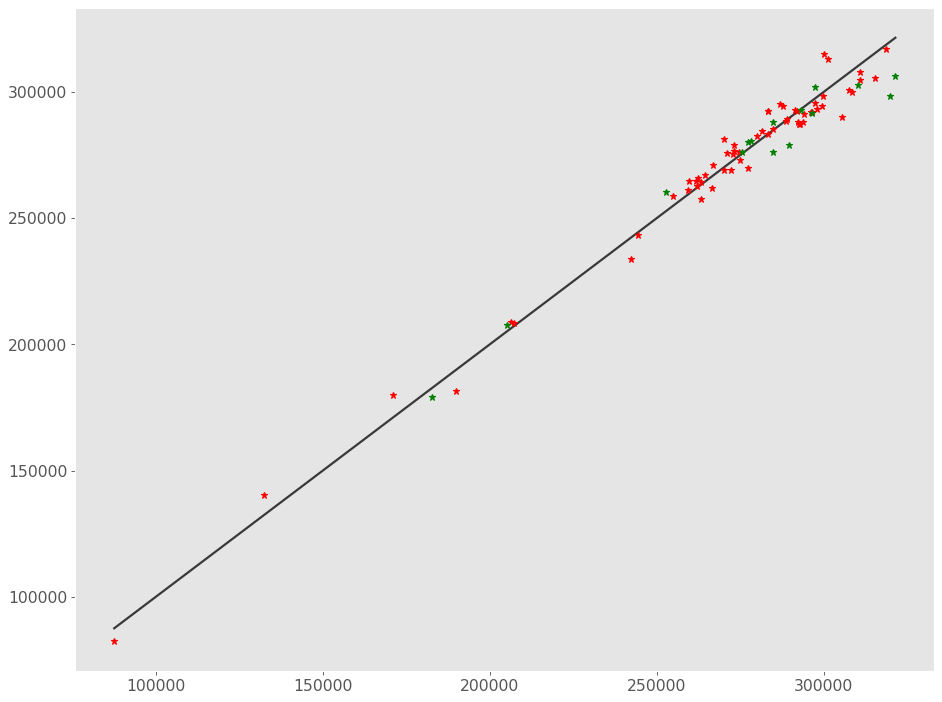

In [232]:
pca = PCA(n_components=15)
X = pca.fit_transform(img_saed[1:])
y = np.asarray(n_atoms_irr[1:])[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

## Predicting Structure Charecteristics

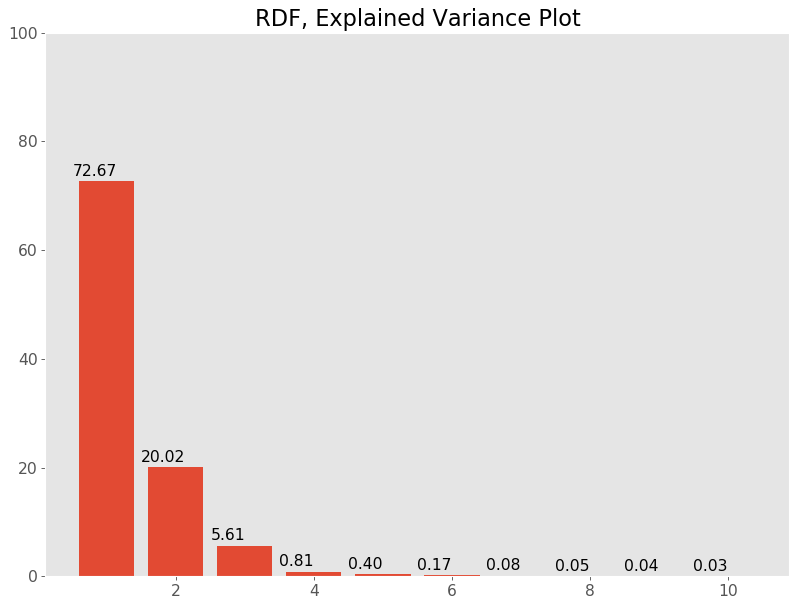

In [244]:
p_spiky = []

for run in runs[1:]:
    f_pdf = "{}/dump.arc.{}_pdf.pkl".format("data/pdfs", run)
    pdf = utils.load_file(f_pdf)
    p_spiky.append(pdf)
    
r_stat=15
len_pixel=50
nbins=(r_stat + 2) * len_pixel + 1
bins=np.linspace(0.0, r_stat + 2, nbins)[1:]

kernel = filters.epanechnikov_kernel(width=0.5, x=bins)
p_smooth = []
for pdf in p_spiky:
    new_pdf = filters.convolve_kernel(kernel, pdf)
    p_smooth.append(new_pdf)
    
y_rdf = np.concatenate([item[None] for item in p_smooth], axis=0)

pca_rdf = PCA(n_components=50)
y_score_rdf = pca_rdf.fit_transform(y_rdf)

ex_var = pca_rdf.explained_variance_ratio_[:10] * 100
plt.bar(np.arange(1, len(ex_var)+1), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("RDF, Explained Variance Plot")
plt.grid(b=None)
plt.show()

In [246]:
%%time
img_saed_list = utils.load_file("data/saed_masked_imgs_hid.pkl")
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

pca_x = PCA(n_components=15)
X_score = pca_x.fit_transform(img_saed)

CPU times: user 29.4 s, sys: 1.36 s, total: 30.7 s
Wall time: 2.16 s


In [166]:
%%time
y_data = np.concatenate([np.ravel(item)[None] for item in tpt_list], axis=0)
pca_y = PCA(n_components=50)

y_score = pca_y.fit_transform(y_data)

CPU times: user 23min 31s, sys: 2min 7s, total: 25min 39s
Wall time: 6min 58s


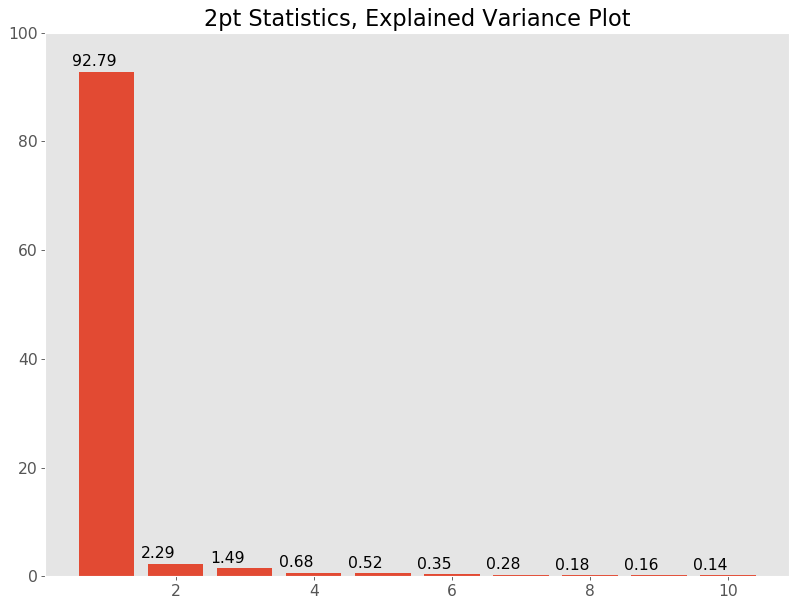

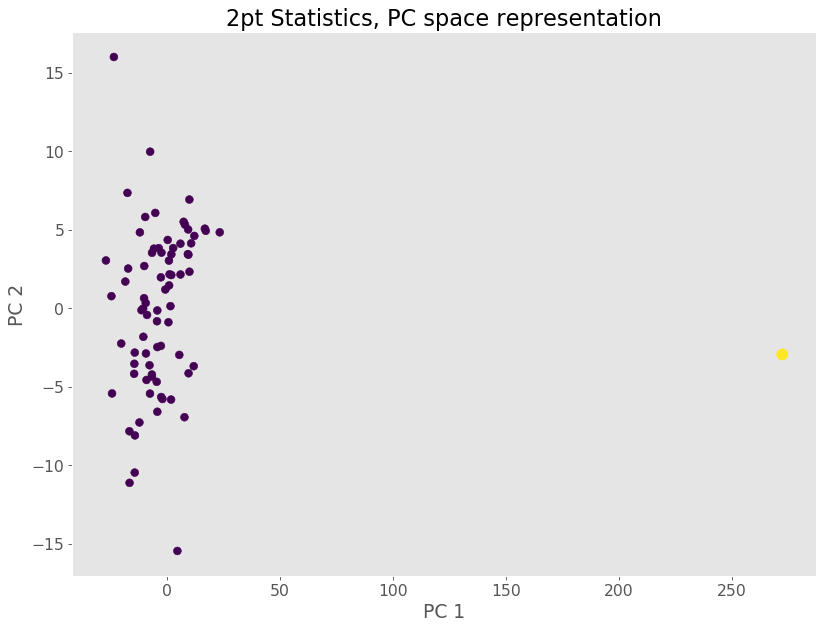

In [189]:
ex_var = pca_y.explained_variance_ratio_[:10] * 100
plt.bar(np.arange(1, len(ex_var)+1), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("2pt Statistics, Explained Variance Plot")
plt.grid(b=None)
plt.show()


label = [50] * len(y_score)
label[0] = 100
plt.scatter(y_score[:,0], y_score[:,1], c=label, s=label)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(b=None)
plt.title("2pt Statistics, PC space representation")
plt.show()

In [249]:
X_score.shape

(77, 15)

In [248]:
y_score_rdf.shape

(76, 50)

test set mae: mean:0.13610, std:0.02734
Normalized mae: 0.60921


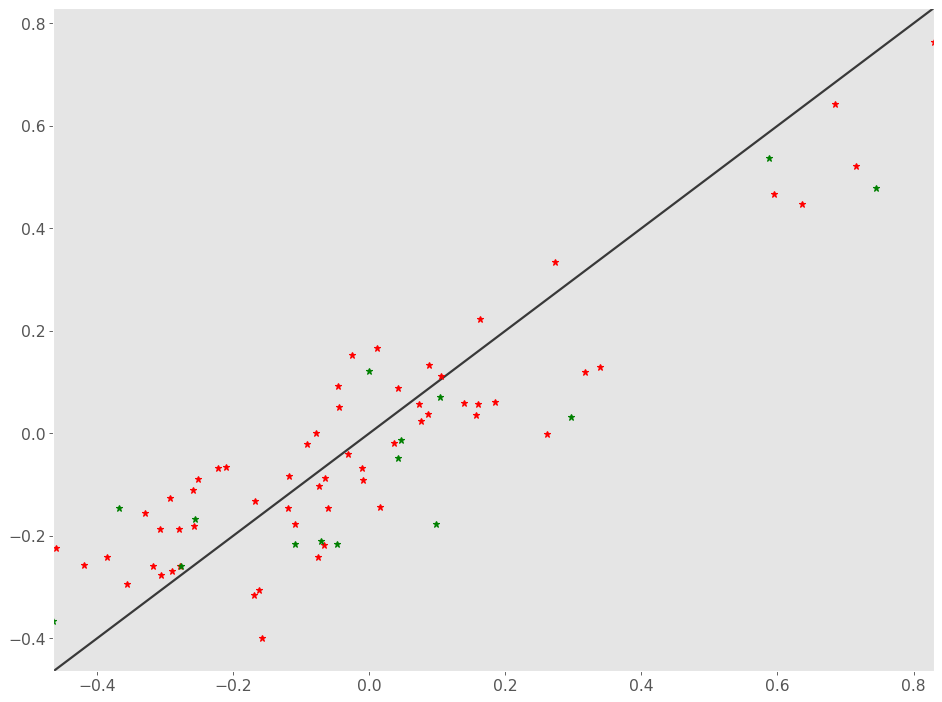

In [250]:
X = X_score[1:]
y = y_score_rdf[:,1][...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.xlim(lims)
plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()

In [207]:
%%time
img_saed_list = utils.load_file("data/saed_masked_imgs_hid.pkl")
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

pca_x = PCA(n_components=15)
X_score = pca_x.fit_transform(img_saed)

CPU times: user 28.1 s, sys: 1.57 s, total: 29.7 s
Wall time: 2.14 s


 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide



test set mae: mean:0.13520, std:0.02664
Normalized mae: 0.60521


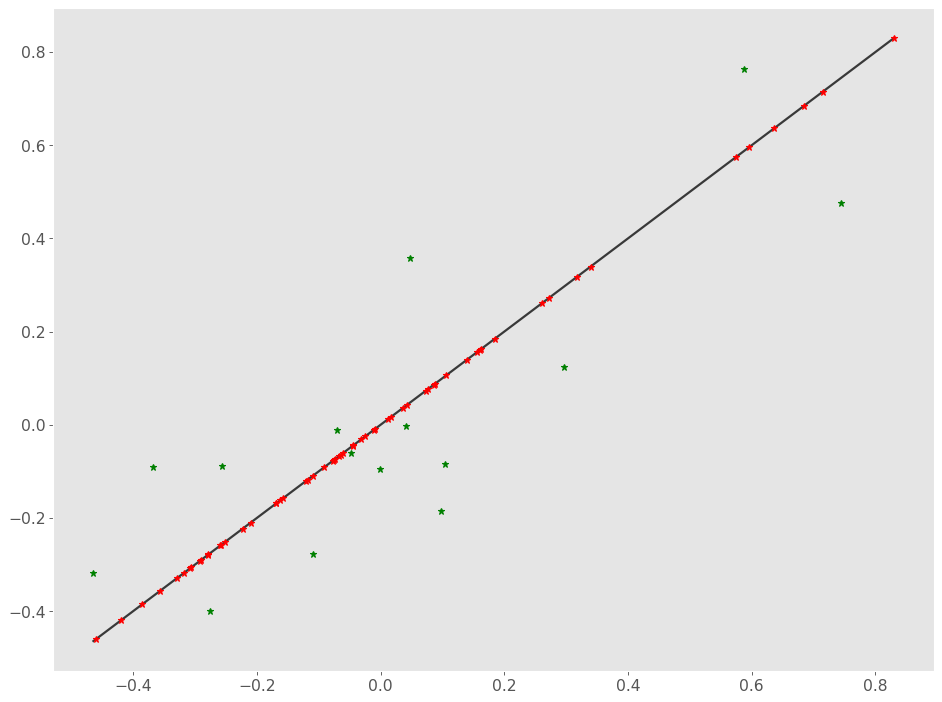

In [251]:
y = y_score_rdf[:,1][...,None]
X = X_score[1:,:]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
errs_gpr = []

for ix, (trn_indx, tst_indx) in enumerate(tqdm.tqdm_notebook(generator)):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]


    transformer_x = lambda x: x
    transformer_y = lambda y: y

    x_inp = transformer_x(X_trn)
    y_inp = transformer_y(y_trn)

    gpr, rbf = gpr_trn(x_inp, y_inp, 
                       scl=[1.0]*X.shape[1], 
                       var=np.var(y_trn), 
                       ard=True)

    y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                               gpr)

    y_prd_m_, _ = gpr_prd(transformer_x(X_trn), 
                               gpr)

    errs_mae.append(maerror(y_prd_m, y_tst))
    errs_gpr.append(np.mean(y_prd_s))

# print("test set mae: {:1.3f}".format(np.mean(errs_mae)))
# print("avg model std: {:1.3f}".format(np.mean(errs_gpr)))
print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# plt.xlim(lims)
# plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()

 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide



test set mae: mean:2.06258, std:0.42601
Normalized mae: 0.48825


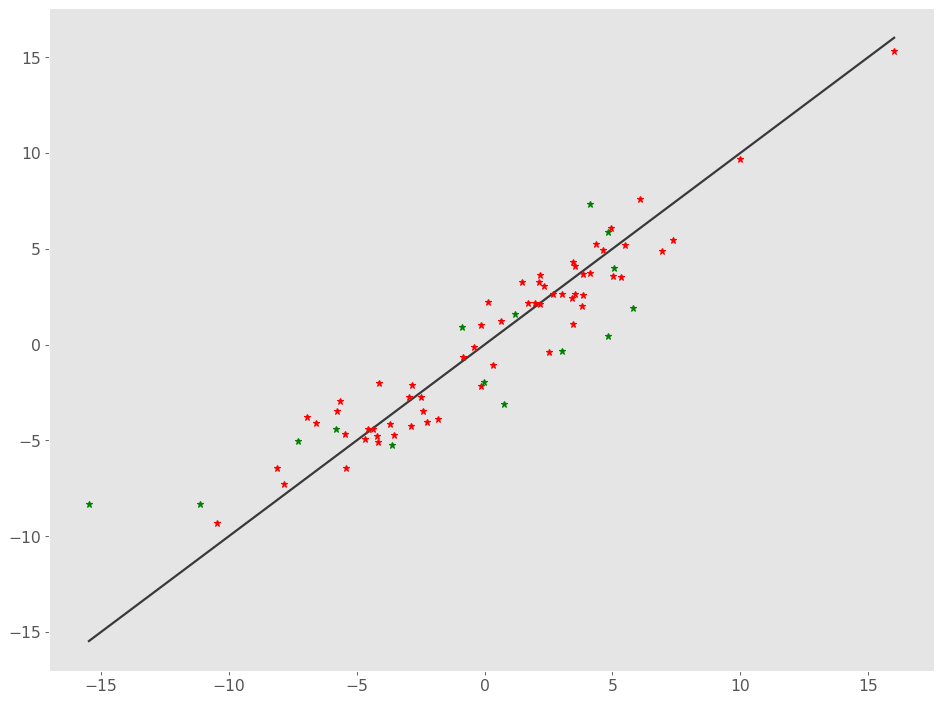

In [208]:
y = y_score[1:,1][...,None]
X = X_score[1:,:]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
errs_gpr = []

for ix, (trn_indx, tst_indx) in enumerate(tqdm.tqdm_notebook(generator)):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]


    transformer_x = lambda x: x
    transformer_y = lambda y: y

    x_inp = transformer_x(X_trn)
    y_inp = transformer_y(y_trn)

    gpr, rbf = gpr_trn(x_inp, y_inp, 
                       scl=[1.0]*X.shape[1], 
                       var=np.var(y_trn), 
                       ard=True)

    y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                               gpr)

    y_prd_m_, _ = gpr_prd(transformer_x(X_trn), 
                               gpr)

    errs_mae.append(maerror(y_prd_m, y_tst))
    errs_gpr.append(np.mean(y_prd_s))

# print("test set mae: {:1.3f}".format(np.mean(errs_mae)))
# print("avg model std: {:1.3f}".format(np.mean(errs_gpr)))
print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# plt.xlim(lims)
# plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()